In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Display defaults. I don't know why these values are used, so I won't change them for now
# plt.rcParams['figure.figsize'] = (10, 10) #large images
# plt.rcParams['image.interpolation'] = 'nearest' #don't interpolate: show square pixels
# plt.rcParams['image.cmap'] = 'gray' #Use grayscale instead of color heatmap

%matplotlib inline

In [2]:
# Load caffe
import os
caffe_root = '/opt/caffe/'
caffe_net = caffe_root + 'models/bvlc_reference_caffenet/'
if os.path.isfile(caffe_net + 'bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'CaffeNet not found. We will try to continue, but you may have to install the reference model'
    

import caffe

CaffeNet found.


In [3]:
caffe.set_mode_cpu()

model_def = caffe_net + 'deploy.prototxt'
model_weights = caffe_net + 'bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def, # Structure of the model
                model_weights, # Trained weights
                caffe.TEST) # Use test mode (don't perform dropout)

In [4]:
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)

print('mean-subtracted values:', zip('BGR', mu))

# Create transformer for input 'data'. I don't know why.
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2, 0, 1)) #move image channels to outermost dimension
transformer.set_mean('data', mu) # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255) # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2, 1, 0)) #swap channels from RGB to BGR

('mean-subtracted values:', [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)])


In [5]:
# load ImageNet labels
labels_file = os.path.join(caffe_root, 'data','ilsvrc12','synset_words.txt')
if not os.path.exists(labels_file):
    !~/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

In [20]:
def predict_imageNet(image):
    net.blobs['data'].data[...] = transformer.preprocess('data', image)

    # perform classification
    net.forward()

    # obtain the output probabilities
    output_prob = net.blobs['prob'].data[0]

    # sort top five predictions from softmax output
    top_inds = output_prob.argsort()[::-1][:5]

    predictions = zip(output_prob[top_inds], labels[top_inds])
    print(predictions)
    return predictions

In [21]:
def detect_faces(image, video = False):
    height, width, depth = image.shape

    classifier = cv2.CascadeClassifier('Detector_XML/haarcascade_frontalface_alt.xml')

    # Resize image for faster processing only for video
    DOWNSCALE = 1
    if(video):
        DOWNSCALE = 4

    mini_size = (int(width/DOWNSCALE), int(height/DOWNSCALE))
    small_img = cv2.resize(image, mini_size)
    
    # detect and store faces
    faces = classifier.detectMultiScale(small_img)
    
    # Add faces to frame, if any was found
    if(len(faces) > 0):
        for face in faces:
            x, y, w, h = [ coordinate * DOWNSCALE for coordinate in face ]
            # Color in BGR instead of RGB!
            color = (0, 255, 0)
            point1 = (x, y)
            point2 = (x + w, y + h)
            cv2.rectangle(image, point1, point2, color)
    return image, faces

In [22]:
def show_image(img, title):
    plt.imshow(img[:,:,::-1])
    plt.title(title)
    plt.axis('off')

In [23]:
def read_from_webcam():
    capture = cv2.VideoCapture(0)
    while(True):
        ret, frame = capture.read()
        
        # This will be used to show the original image later
        img = frame.copy()

        # Detects and draws a rectangle around the detected faces
        frame, faces = detect_faces(frame, True)
        cv2.imshow('frame', frame)

        # Quit on `q` or `esc`
        pressed_key = cv2.waitKey(1) & 0xFF
        if(pressed_key == ord('q') or pressed_key == 27): #ESCape
            break
    
    capture.release()
    cv2.destroyAllWindows()
    return img, frame, faces

In [33]:
def read_from_file():
    image = cv2.imread('pics/pessoas-dogs4.png')
    frame = image.copy()
    predict_imageNet(frame)
    frame, faces = detect_faces(frame)
    return image, frame, faces

In [34]:
def decide_input_form():
    options = {'1': {'label': 'Webcam', 'function': 'read_from_webcam()'},
               '2': {'label': 'File', 'function': 'read_from_file()'},
              }
    while True:
        for key, value in options.iteritems():
            print(' {}: {}'.format(key, value['label']))
        option = raw_input('Choose an input option: ')
        try:
            function = options[str(option)]['function']
#             if(function)
            original, detection, faces = eval(function)
            print('\n\n')
            show_image(detection, 'Detection results')
#             show_image(original, 'Original Image')
            print('We found {} faces'.format(len(faces)))
            break
        except KeyError, e:
            print('Invalid option!')

 1: Webcam
 2: File
Choose an input option: 2
[611 411 721 750 496]
[(0.037168693, 'n03598930 jigsaw puzzle'), (0.029817689, 'n02730930 apron'), (0.029015897, 'n03938244 pillow'), (0.02680837, 'n04033995 quilt, comforter, comfort, puff'), (0.026059315, 'n03026506 Christmas stocking')]



We found 3 faces


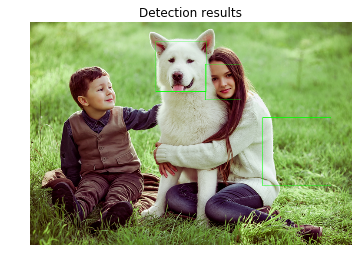

In [35]:
decide_input_form()